## hammurabiX tutorial 01
(we recommend users to run tutorials on docker image)

### hammurabiX with given field models

This tutorial describes the basic usage of the python wrapper which depends on an XML parameter file. 

In [1]:
import matplotlib
import numpy as np
import healpy as hp
import sys
sys.path.append('../hampyx/')
import hampyx as hpx

matplotlib.use('Agg')
%matplotlib inline

### hampyx, the hammurabiX python wrapper

The Hampyx init function:

```
def __init__(self,
             xml_path='./params.xml',
             exe_path=None)
```

The path to the executable is searched automatically through the system environment.

Users can store different sets of `hammuarbiX` parameters in different `XML` files.

working directory is set as the same directory as this file, it relies on subprocess to fork `C++` routine and passing data through disk, and by doing so, it is not fast.

Notice that `hammurabiX` uses `XML` input parameter file, which may look like:

```
<root>
    ...
    <key1 tag1='content1'>
        ...
        <key2 tag21='content21' tag22='content22'/>
        ...
    </key1>
    ...
</root>
```
We highly recommend users to read the template_params.xml first, where sufficient captions have been provided.

methods/functions:

- Import class

```
In []: import hampyx as hpx
```

- Initialize instance/object

```
In []: object = hpx.Hampyx (exe_path, xml_path)
```

- Modify parameter value from base xml file to temp `XML` file

```
In []: object.mod_par (keychain=['key1','key2',...], attrib={'tag':'content'})
```

- Add new parameter with or without attributes.

```
In []: object.add_par (keychain=['key1','key2',...], subkey='keyfinal', attrib={'tag':'content'})
```

The new parameter subkey, will be added at the path defined by keychain.

- Delete parameter

```
In []: object.del_par (keychain=['key1','key2',...],opt='')
```

If additional argument opt='all', then all matching parameters will be deleted.

The strings 'key1', 'key2', etc represent the path to the desired parameter, going through the `XML` file.

The "tag" is the label for the parameter: eg. "Value" or "cue" or "type".

The "content" is the content under the tag: eg. the string for the tag "filename"

- Look through the parameter tree in python

```
In []: object.print_par(keychain=['key1','key2',...])
```

This will return the current value of the parameter in the `XML` associated with the path "key1/key2/.../keyfinal/".

- Run the executable

```
In []: object(verbose=True/False)
```

If additional verbose=True (by default is False) hampyx_run.log and hampyx_err.log will be dumped to disk
notice that dumping logs is not thread safe, use quiet mode in threading.

After this main routine, object.sim_map will be filled with simulation outputs from hammurabiX
the structure of object.sim_map contains arrays under entries:

(we give up nested dict structure for the convenience of Bayesian analysis)

```
object.sim_map[('sync',str(freq),str(Nside),'I')] # synchrotron intensity map at 'frequency' 
object.sim_map[('sync',str(freq),str(Nside),'Q')] # synchrotron Q map at 'frequency' 
object.sim_map[('sync',str(freq),str(Nside),'U')] # synchrotron U map at 'frequency' 
object.sim_map[('sync',str(freq),str(Nside),'PI')] # synchrotron pol. intensity at 'frequency' 
object.sim_map[('sync',str(freq),str(Nside),'PA')] # synchrotron pol. angle at 'frequency' (IAU convention)
object.sim_map[('fd','nan',str(Nside),'nan')] # Faraday depth map
object.sim_map[('dm','nan',str(Nside),'nan')] # dispersion measure map
```

#### In the following we will present how to use above functions

#### initialize

In [2]:
xmlpath = '../templates/params_template.xml'
sim = hpx.Hampyx(xml_path=xmlpath)

# print executable path
print (sim.exe_path)
# print parameter file path
print (sim.xml_path)
# print root->observable
sim.print_par(['observable'])

/usr/local/hammurabi/bin/hamx
/home/lab/hamx/templates/params_template.xml
observable {}
|-->  dm {'cue': '1', 'filename': 'dm.fits', 'nside': '8'}
|-->  faraday {'cue': '1', 'filename': 'fd.fits', 'nside': '64'}
|-->  sync {'cue': '1', 'freq': '30', 'filename': 'sync_30.fits', 'nside': '16'}
|-->  sync {'cue': '1', 'freq': '1.4', 'filename': 'sync_1.4.fits', 'nside': '32'}
|-->  dust {'cue': '1', 'freq': '200', 'filename': 'dust_200.fits', 'nside': '16'}
|-->  dust {'cue': '1', 'freq': '300', 'filename': 'dust_300.fits', 'nside': '32'}


- once the `XML` parameter file is read in, the `XML` tree is deep copied and so the following modifications does not affect the external file, unless explicit write the tree to the disk

#### use `del_par` to remove dust emission outputs

In [3]:
sim.del_par(['observable','dust'],'all')
sim.print_par(['observable'])

observable {}
|-->  dm {'cue': '1', 'filename': 'dm.fits', 'nside': '8'}
|-->  faraday {'cue': '1', 'filename': 'fd.fits', 'nside': '64'}
|-->  sync {'cue': '1', 'freq': '30', 'filename': 'sync_30.fits', 'nside': '16'}
|-->  sync {'cue': '1', 'freq': '1.4', 'filename': 'sync_1.4.fits', 'nside': '32'}


#### use `mod_par` to change synchrotron emission output resolution

In [4]:
sim.mod_par(['observable','sync'],{'nside':'2'})
sim.print_par(['observable'])

observable {}
|-->  dm {'cue': '1', 'filename': 'dm.fits', 'nside': '8'}
|-->  faraday {'cue': '1', 'filename': 'fd.fits', 'nside': '64'}
|-->  sync {'cue': '1', 'freq': '30', 'filename': 'sync_30.fits', 'nside': '2'}
|-->  sync {'cue': '1', 'freq': '1.4', 'filename': 'sync_1.4.fits', 'nside': '32'}


#### use `add_par` to add another synchrotron emission output

In [5]:
sim.add_par(['observable'],'sync',{'cue':'1','freq':'10','filename':'sync_10.fits','nside':'8'})
sim.print_par(['observable'])

observable {}
|-->  dm {'cue': '1', 'filename': 'dm.fits', 'nside': '8'}
|-->  faraday {'cue': '1', 'filename': 'fd.fits', 'nside': '64'}
|-->  sync {'cue': '1', 'freq': '30', 'filename': 'sync_30.fits', 'nside': '2'}
|-->  sync {'cue': '1', 'freq': '1.4', 'filename': 'sync_1.4.fits', 'nside': '32'}
|-->  sync {'cue': '1', 'freq': '10', 'filename': 'sync_10.fits', 'nside': '8'}


- upon adding an existed key with existed attributes, a ValueError will be raised

#### check field i/o settings

In [6]:
sim.print_par(['fieldio'])

fieldio {}
|-->  breg {'read': '0', 'write': '0', 'filename': 'breg.bin'}
|-->  brnd {'read': '0', 'write': '0', 'filename': 'brnd.bin'}
|-->  tereg {'read': '0', 'write': '0', 'filename': 'tereg.bin'}
|-->  ternd {'read': '0', 'write': '0', 'filename': 'ternd.bin'}
|-->  cre {'read': '0', 'write': '0', 'filename': 'cre.bin'}


#### check grid settings

In [7]:
sim.print_par(['grid'])

grid {}
|-->  observer {}
|-->  box_breg {}
|-->  box_brnd {}
|-->  box_tereg {}
|-->  box_ternd {}
|-->  box_dreg {}
|-->  box_drnd {}
|-->  box_cre {}
|-->  shell {}


- grid->observer hosts the galactic-centric location of the observer (in kpc unit)

In [8]:
sim.print_par(['grid','observer'])

observer {}
|-->  x {'value': '-8.3'}
|-->  y {'value': '0'}
|-->  z {'value': '6'}


- shell hosts the LoS integral settings

In [9]:
sim.print_par(['grid','shell'])
print()
sim.print_par(['grid','shell','layer'])
print()
sim.print_par(['grid','shell','layer','auto'])
print()
sim.print_par(['grid','shell','layer','manual'])

shell {}
|-->  layer {'type': 'auto'}
|-->  oc_r_min {'value': '0.0'}
|-->  oc_r_max {'value': '30.0'}
|-->  gc_r_min {'value': '0.0'}
|-->  gc_r_max {'value': '20.0'}
|-->  gc_z_min {'value': '-10.0'}
|-->  gc_z_max {'value': '10.0'}
|-->  oc_r_res {'value': '0.01'}
|-->  oc_lat_min {'value': '-90.'}
|-->  oc_lat_max {'value': '90.'}
|-->  oc_lon_min {'value': '0.'}
|-->  oc_lon_max {'value': '360.'}

layer {'type': 'auto'}
|-->  auto {}
|-->  manual {}

auto {}
|-->  shell_num {'value': '1'}
|-->  nside_sim {'value': '32'}

manual {}
|-->  cut {'value': '0.5'}
|-->  nside_sim {'value': '32'}
|-->  nside_sim {'value': '64'}


#### check magnetic field settings

In [10]:
sim.print_par(['magneticfield'])

magneticfield {}
|-->  regular {'cue': '1', 'type': 'unif'}
|-->  random {'cue': '0', 'type': 'local', 'seed': '0'}


#### check thermal electron field settings

In [11]:
sim.print_par(['thermalelectron'])

thermalelectron {}
|-->  regular {'cue': '1', 'type': 'unif'}
|-->  random {'cue': '0', 'type': 'global', 'seed': '0'}


#### check cosmic ray electron field settings

In [12]:
sim.print_par(['cre'])

cre {'cue': '1', 'type': 'unif'}
|-->  analytic {}
|-->  unif {}


#### users are recommended to check all parameters to make sure they are set as expected, then we can start to run the simulation routine

- the optional input argument verbose=True/False determines whether the log of hammurabiX execution will be printed

In [13]:
sim(True)

- get the output entries

In [14]:
for key in sim.sim_map.keys():
    print (key)

('dm', 'nan', '8', 'nan')
('fd', 'nan', '64', 'nan')
('sync', '30', '2', 'I')
('sync', '30', '2', 'Q')
('sync', '30', '2', 'U')
('sync', '30', '2', 'PI')
('sync', '30', '2', 'PA')
('sync', '1.4', '32', 'I')
('sync', '1.4', '32', 'Q')
('sync', '1.4', '32', 'U')
('sync', '1.4', '32', 'PI')
('sync', '1.4', '32', 'PA')
('sync', '10', '8', 'I')
('sync', '10', '8', 'Q')
('sync', '10', '8', 'U')
('sync', '10', '8', 'PI')
('sync', '10', '8', 'PA')


- illustrate simulated map behind one entry

/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:988: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/usr/local/lib/python3.6/dist-packages/healpy/projaxes.py:958: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


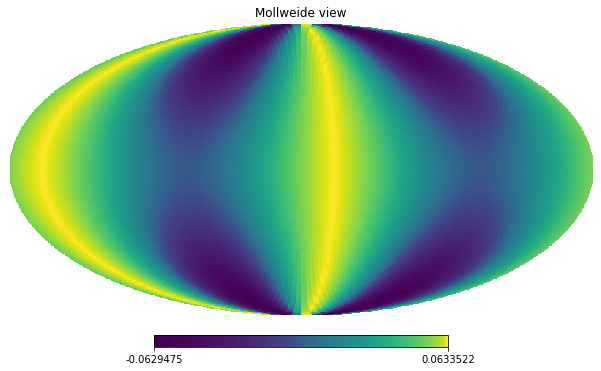

In [15]:
out_sync_Q = sim.sim_map[('sync', '1.4', '32', 'Q')]
hp.mollview(out_sync_Q,norm='hist')

end